## Overview

The goal of a recommendation system is to expose people to items that they will like. In exact terms, a recommendation system predicts the future preference of a set of items for a user, and recommends the top items from this set. In today's world, due to the internet and its global reach, people have more options to choose from than ever before.

Consider buying an album from a traditional music store where the options are always limited and mainly depend upon size and type of the store. There is a physical limitation to how many songs, albums, and artists can be offered. An online product like Spotify, however has a much higher ceiling in terms of storage space. With this new method of selecting products, recommendation systems are a popular way for users to sort through millions of songs to find the ones that are customized exactly for them. Recommendation systems cast a direct impact on profitability and customer satisfaction for most businesses today. With the nearly limitless options consumers have for products online, they need some guidance!

This idea can be represented by a concept called the "Long Tail," which is a set of statistical distributions that have a very long "tail" of the distribution, representing many occurrences of low frequency things. In the context of consumer products, there are some products that everyone is going to buy: light bulbs, toilet paper, bread etc. There are also items that are far more obscure: specific toys, sports equipment, movies. Recommendation systems are made to help consumers tap into this long tail to assist them in picking from the endless number of options that are made available to them via the internet.

<div>
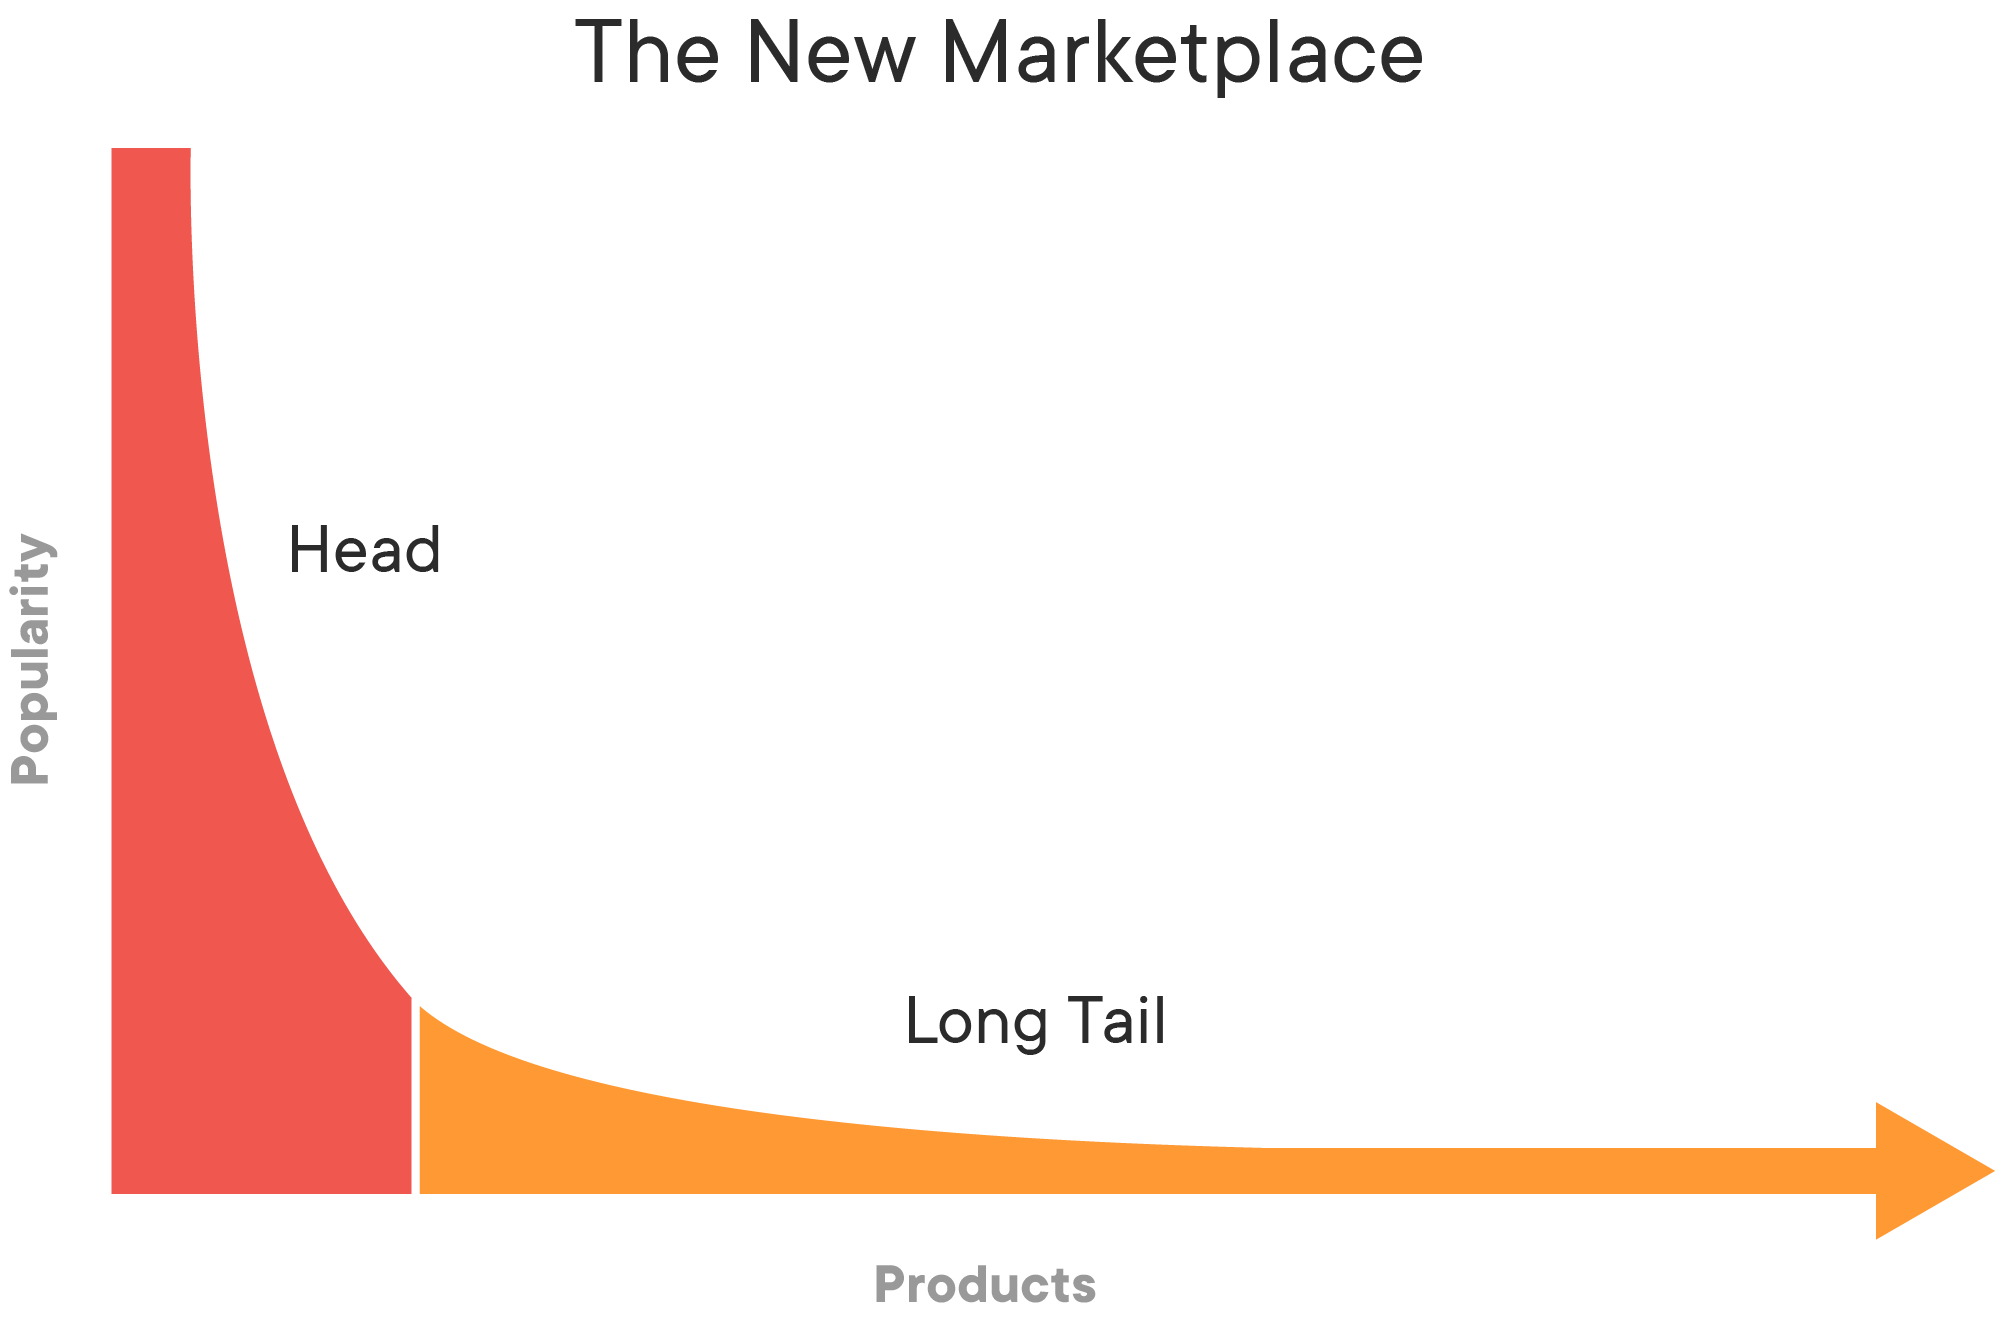
</div>

Here's a formal definition of recommendation systems from authors [Bo Xiao and Izak Benbasat, 2017](https://misq.umn.edu/e-commerce-product-recommendation-agents-use-characteristics-and-impact.html):

> "Recommendation Systems are software agents that elicit the interests and preferences of individual consumers […] and make recommendations accordingly. They have the potential to support and improve the quality of the decisions consumers make while searching for and selecting products online."

## Recommendation System Approaches

There are two main types of recommendation systems: **unpersonalized** and **personalized**. This project will focus on personalized recommendation systems because that's where data scientists can provide the most value to companies, but to start off, let's investigate some unpersonalized systems because they can be productive in their own right.

### Type #1: Unpersonalized Recommendations

Unpersonalized recommendation systems have been happening since way before machine learning was ever in the public knowledge base. An example of an unpersonalized recommendation would be on YouTube when it recommends the most viewed videos. These are videos that the most people have watched. For the most part, these recommendations aren't too bad. After all, there's a reason why things are popular. This approach, however, is not going to help more niche videos get exposure. It also won't be immensely beneficial to those who have very particular tastes. Of course, there are times when a simple approach like this might be best. An example of a simple popularity recommender working well is with the news. There's a high chance that everyone who visits a news website is going to want to see whatever is the most popular at that moment in time.

### Type #2: Personalized Recommendations

According to Todd Yellin, Netflix’s vice president of product innovation:

> “Personalization is about creating the right connection between a viewer and their content.”
> [SOURCE](https://www.altexsoft.com/blog/recommender-system-personalization/)

In other words, personalization is the way to match the right types of services, products, or content to the right users. When approached appropriately, it helps improve user engagement — any interactions people have with a product, website, app, etc.

These days, the true power of customer experience personalization can be realized with the help of machine learning. By utilizing ML algorithms and data, it is possible to create smart models that can precisely predict customer intent and as such provide quality one-to-one recommendations.

At the same time, the continuous growth of available data has led to information overload — when too many choices complicate decision-making. Primarily developed to help users deal with the large range of choices they encounter, recommender systems come into play.

Recommender systems, also known as recommender engines, are information filtering systems that provide individual recommendations in real-time. As powerful personalization tools, recommendation systems leverage machine learning algorithms and techniques to give the most relevant suggestions to particular users by learning data (e.g., past behaviors) and predicting current interests and preferences.

<div>
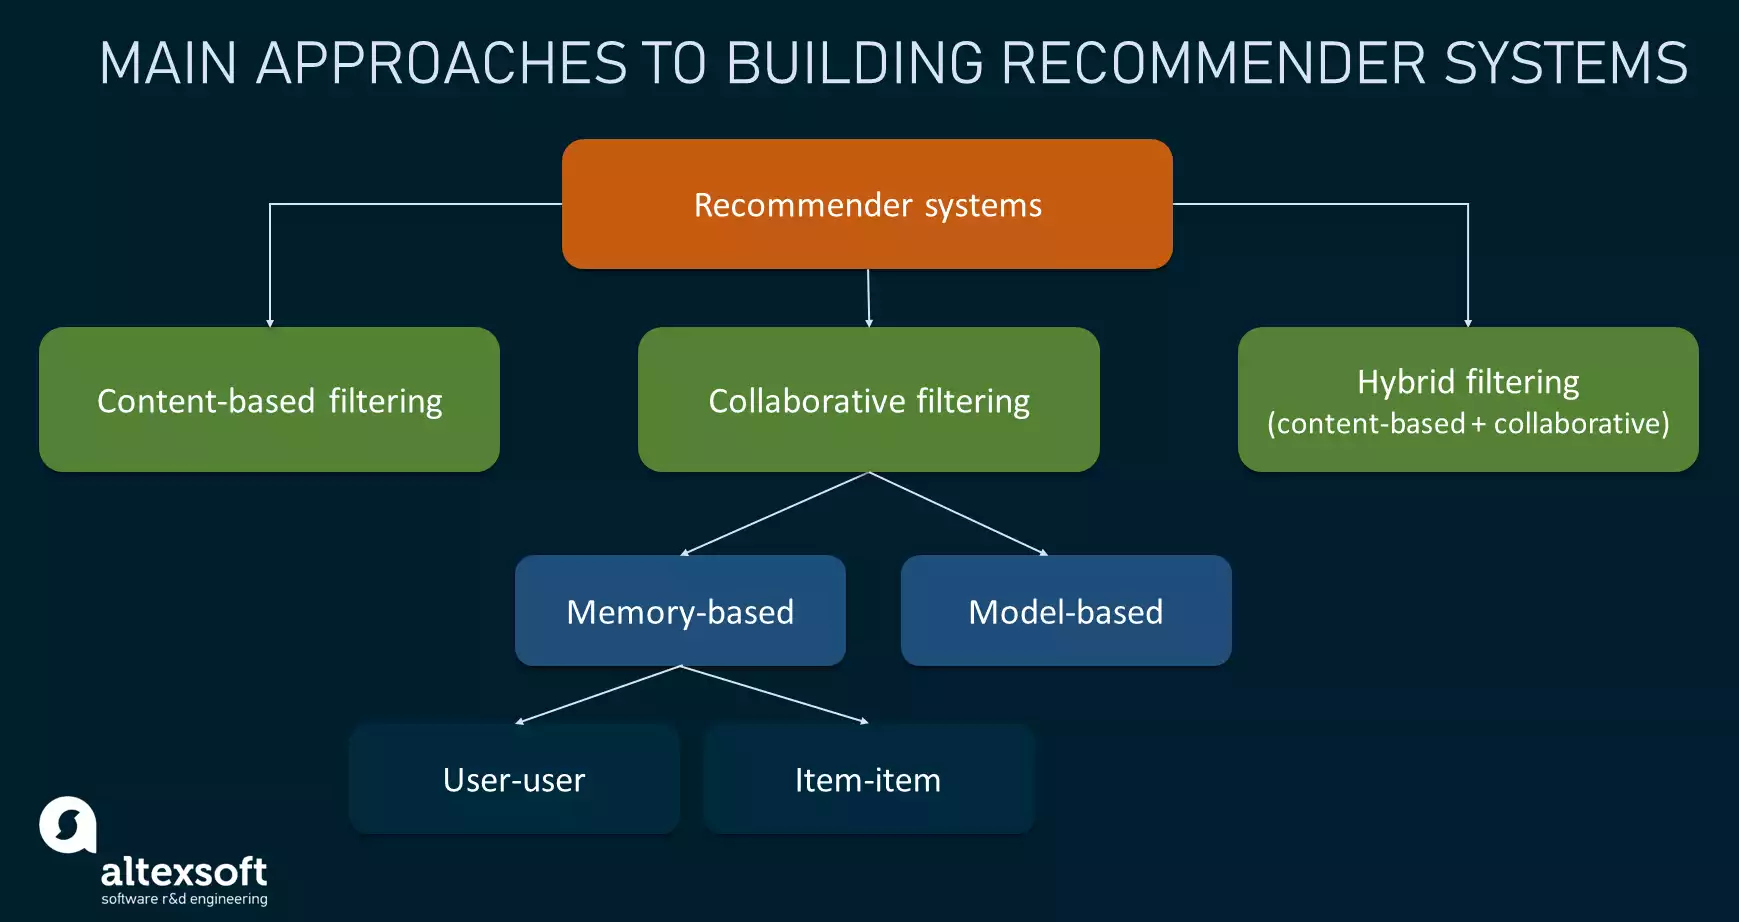
</div>

## Approaches

This project is going to use all 3 main approaches to predict what movie a user would prefer:

* **Content-based filtering**, which generates predictions by analyzing item attributes and searching for similarities between them
* **Collaborative filtering**, which generates predictions by analyzing user behavior and matching users with similar tastes
* **Hybrid filtering**, which combines two or more models.

Now that we have a general overview of what a recommendation system is and how it works, let's dive in to our data.

## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import squarify
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
%matplotlib inline

## Load the Data

This project is going to use 4 datasets, some of which have multiple files within them:

1. [Wikipedia Movie Plots](https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots)
  * `wiki_movie_plots_deduped`
2. [MovieLens 100K](https://grouplens.org/datasets/movielens/latest/)
  * `links`
  * `movies`
  * `ratings`
  * `tags` - I DONT THINK WE NEED THIS
3. [IMDB](https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset)
  * `ratings_data`
  * `basic_name_data` - I DONT THINK WE NEED THIS
  * `title_basics_data`
  * `title_data` - I DONT THINK WE NEED THIS
  * `title_principals_data` - I DON'T THINK WE NEED THIS
4. [Streaming Platforms](https://www.kaggle.com/datasets/javagarm/movies-on-ott-platforms)
  * `MoviesOnStreamingPlatforms_updated`

## Wikipedia Data

There is 1 file within the Wikipedia Data set: `wiki_movie_plots_deduped`.

In [2]:
# Load the data
plots_df = pd.read_csv('Data/Wikipedia Movie Plots/wiki_movie_plots_deduped.csv')

# Preview the data
plots_df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


The first type of model we are going to build will use content-based collaborative filtering, specifically on the `Plot` column. Before doing that, let's take a closer look at our data.

# Preliminary Exploratory Data Analysis

In [3]:
# Check for missing values
plots_df.isna().sum()

Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64

In [4]:
# Value counts of `Genre`
plots_df['Genre'].value_counts()

unknown                          6083
drama                            5964
comedy                           4379
horror                           1167
action                           1098
                                 ... 
cbc-tv miniseries                   1
bio-drama                           1
national film board docudrama       1
cult drama                          1
horror romantic comedy              1
Name: Genre, Length: 2265, dtype: int64

Even though we only have missing values in the `Cast` column, we can see above that we are missing plenty of information in the `Genre` column as well because it includes the entry `unknown`. Let's take a look at our dataframe in a bit further detail.

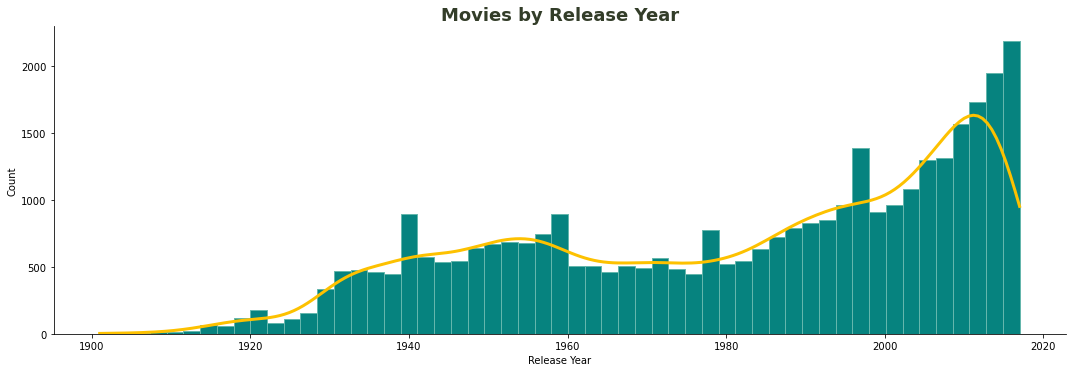

In [5]:
# Create displot
sns.displot(data=plots_df, x='Release Year', kind='hist', kde=True, bins=55,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)

# Label our headings
plt.title('Movies by Release Year', fontsize=18, weight=600, color='#333d29');

It looks like our movies by release year is skewed left. Or in other words, we have more movies released in the current era, which does make sense when you think about it logically.

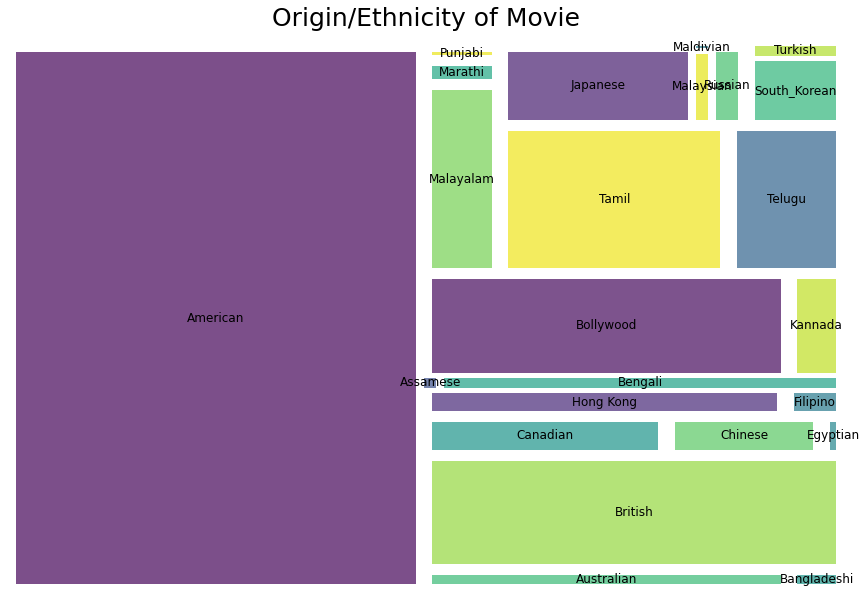

In [6]:
# Count origin column
origin_info = Counter(plots_df['Origin/Ethnicity'])

# Create plot
plt.figure(figsize=(15, 10))
plt.title("Origin/Ethnicity of Movie", fontsize=25, pad=20)
squarify.plot(origin_info.values(), label=origin_info.keys(), text_kwargs={'fontsize':12}, 
              bar_kwargs={'alpha':.7}, pad=True)
plt.axis("off");

We can see that the vast majority of our movies are American. 

Now that we have a decent understanding of our first dataframe, let's move onto our first model.

# Modeling

Let's recall our graph and goals for this project. 

* **Content-based filtering**, which generates predictions by analyzing item attributes and searching for similarities between them
* **Memory-based Collaborative filtering**, which generates predictions by analyzing user behavior and matching users with similar tastes
* **Hybrid filtering**, which combines two or more models.

# Content-based Filtering

The first recommender system we are going to create is **content-based**. For this model, we will first generate recommendations of movies based on a watched movie. From there, we will recommend movies based on the genre of a watched movie.

## TF-IDFVectorizer

Not all words in a document carry equal weight. We know this from looking at stopwords. But the words that were in the vocabulary were all given equal weighting.

Should this always be the case...?

For example, consider a corpus of documents on dogs. Now, it is obvious that all these documents will frequently contain the word dog. Therefore, the appearance of the word dog isn't as important as another word that only appears in a few documents.

**TF-IDFVectorizer (Term Frequency-Inverse Document Frequency)** takes the aforementioned point into consideration and assigns weights to each word according to the following formula.

$$\large IDF(t) = log_e(\frac{Total\ Number\ of\ Documents}{Number\ of\ Documents\ with\ t\ in\ it})$$

[SCIKIT LEARN DOCUMENTATION](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Just keep in mind that the weight of a word in a document is greater if it occurs more frequently in that document and is present in fewer documents. The weight takes values between 0 and 1.

We will be using TF-IDFVectorizer because some words occur much more frequently in plot descriptions than others. It is therefore a good idea to assign weights to each word in a document according to the TF-IDF formula. Another reason to use TF-IDF is that it speeds up the calculation of the cosine similarity score between a pair of documents. 

We will mainly use the `Plot` information from our `non_dup_movies` dataframe. First, we will clean up the `Plot` column by lowering the case of all of the words and removing the punctuation. From there we will fit and transform the `Clean_Plot` column using a `TfidfVectorizer`. 

## Cosine Similarity Score

The cosine score is extremely robust and easy to calculate (especially when used in conjunction with TF-IDFVectorizer).

The cosine similarity score between two documents, x and y, is as follows:

$$\large cosine(x,y) = \frac{X \cdot y^T}{\parallel x \parallel \cdot \parallel y \parallel}$$

The cosine score can take any value between -1 and 1. The higher the cosine score, the more similar the documents are to each other. We now have a good theoretical base to proceed to build the content-based recommenders using Python.

## Plot description-based recommender

Our plot description-based recommender will take in a movie title as an argument and output a list of movies that are most similar based on their plots. These are the steps we are going to perform in building this model:

1. Obtain the data required to build the model
2. Create TF-IDF vectors for the plot description (or overview) of every movie
3. Compute the pairwise cosine similarity score of every movie
4. Write the recommender function that takes in a movie title as an argument and outputs movies most similar to it based on the plot

In [7]:
# Display our dataframe
plots_df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [8]:
# Standardize the case for our `Plot`
plots_df['Clean_Plot'] = plots_df['Plot'].str.lower()

# Remove punctuation
plots_df['Clean_Plot'] = plots_df['Clean_Plot'].str.translate(str.maketrans('', '', string.punctuation))

In [9]:
# Instantiate a vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit the vectorizer on non_dup_movies['Plot'] and transform it
movies_vectorized = tfidf.fit_transform(plots_df['Clean_Plot'])

# Preview the shape
movies_vectorized.shape

(34886, 178166)

We can see that the vectorizer has created a 178,166-dimensional vector for the overview of every movie.

### Compute the Cosine Similarity Score

The next step is to calculate the pairwise cosine similarity score of every movie. In other words, we are going to create a 34,886 × 34,886 matrix, where the cell in the ith row and jth column represents the similarity score between movies i and j. We can easily see that this matrix is symmetric in nature and every element in the diagonal is 1, since it is the similarity score of the movie with itself.

Like `TF-IDFVectorizer`, scikit-learn also has functionality for computing the aforementioned similarity matrix. Calculating the cosine similarity is, however, a computationally expensive process. Fortunately, since our movie plots are represented as TF-IDF vectors, their magnitude is always 1. Hence, we do not need to calculate the denominator in the cosine similarity formula as it will always be 1. Our work is now reduced to computing the much simpler and computationally cheaper dot product (a functionality that is also provided by scikit-learn).

In [10]:
# Apply `linear_kernel` to our vector
cosine_sim = linear_kernel(movies_vectorized, movies_vectorized)

# Preview the results
cosine_sim

array([[1.        , 0.03026373, 0.00777599, ..., 0.        , 0.00371386,
        0.        ],
       [0.03026373, 1.        , 0.00892876, ..., 0.        , 0.01005604,
        0.0191672 ],
       [0.00777599, 0.00892876, 1.        , ..., 0.00766691, 0.00622522,
        0.        ],
       ...,
       [0.        , 0.        , 0.00766691, ..., 1.        , 0.0115371 ,
        0.00613037],
       [0.00371386, 0.01005604, 0.00622522, ..., 0.0115371 , 1.        ,
        0.00300791],
       [0.        , 0.0191672 , 0.        , ..., 0.00613037, 0.00300791,
        1.        ]])

With the similarity scores of every movie with every other movie, we are now in a very good position to write our final recommender function.

### Building the recommender function

The final step is to create our recommender function. However, before we do that, let's create a reverse mapping of movie titles and their respective indices. In other words, let's create a pandas series with the index as the movie title and the value as the corresponding index in the main DataFrame:

In [11]:
# Create variable `indices` to pull the index of each movie
indices = pd.Series(plots_df.index, index=plots_df['Title']).drop_duplicates()

# Preview the results
indices

Title
Kansas Saloon Smashers                  0
Love by the Light of the Moon           1
The Martyred Presidents                 2
Terrible Teddy, the Grizzly King        3
Jack and the Beanstalk                  4
                                    ...  
The Water Diviner                   34881
Çalgı Çengi İkimiz                  34882
Olanlar Oldu                        34883
Non-Transferable                    34884
İstanbul Kırmızısı                  34885
Length: 34886, dtype: int64

We will perform the following steps in building the recommender function:

1. Declare the title of the movie as an argument.
2. Obtain the index of the movie from the indices reverse mapping.
3. Get the list of cosine similarity scores for that particular movie with all movies using cosine_sim. Convert this into a list of tuples where the first element is the position and the second is the similarity score.
4. Sort this list of tuples on the basis of the cosine similarity scores.
5. Get the top 10 elements of this list. Ignore the first element as it refers to the similarity score with itself (the movie most similar to a particular movie is obviously the movie itself).
6. Return the titles corresponding to the indices of the top 10 elements, excluding the first:

In [12]:
def get_recommendations(title, cosine_sim=cosine_sim):
    
    # Obtain the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    # And convert it into a list of tuples as described above
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies, ignore the first movie
    sim_scores = sim_scores[1:11]
    
    # Find the movies that match with those indicies
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return pd.DataFrame(plots_df['Title'].iloc[movie_indices])

Let's try it out!

In [13]:
get_recommendations('Toy Story')

,Title
13574,Toy Story 2
5342,Destination Meatball
15948,Toy Story 3
5203,Puny Express
16619,Nebraska
16606,LUV
3731,The Barber of Seville
2811,Girl from Havana
6608,Mr. B Natural
22145,It's a Boy Girl Thing


We see that our recommender has suggested all of Toy Story's sequels in its top-10 list. 

It goes without saying that a person who loves Toy Story is very likely to have a thing for Disney movies. They may also prefer to watch animated movies. Unfortunately, our plot description recommender isn't able to capture all this information.

Therefore next we will build a recommender that uses more advanced metadata, such as genres, cast, crew, and keywords (or sub-genres). This recommender will be able to do a much better job of identifying an individual's taste for a particular director, actor, sub-genre, and so on.

# Metadata-based Recommender

To build this model, we will be using the following metdata:

* The genre of the movie
* The director of the movie
* Major stars and cast
* Average rating
* Number of IMDB votes

## IMDB Dataset

Now we are going to load in information from our second dataset, The IMDB Data set. There are 5 files located within this dataset:

  * `ratings_data`
  * `basic_name_data`
  * `title_basics_data`
  * `title_data` -- I DON'T THINK WE NEED THIS
  * `title_principals_data` 

In [14]:
# Load the data
imdb_ratings_df = pd.read_csv('Data/IMDB/ratings_data.tsv', sep='\t')

# Preview the data
imdb_ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1923
1,tt0000002,5.8,259
2,tt0000003,6.5,1737
3,tt0000004,5.6,174
4,tt0000005,6.2,2550


In [15]:
# Load the data
name_df = pd.read_csv('Data/IMDB/basic_name_data.tsv', sep='\t')

# Preview the data
name_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0050419,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0038355,tt0037382,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0056404,tt0057345,tt0049189,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0080455,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986"


In [16]:
# Load the data
title_basics_df = pd.read_csv('Data/IMDB/title_basics_data.tsv', sep='\t', low_memory=False)

# Preview the data
title_basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [17]:
# Load the data
title_principals_df = pd.read_csv('Data/IMDB/title_principals_data.tsv', sep='\t')

# Preview the data
title_principals_df

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N
...,...,...,...,...,...,...
53173242,tt9916880,4,nm10535738,actress,\N,"[""Horrid Henry""]"
53173243,tt9916880,5,nm0996406,director,principal director,\N
53173244,tt9916880,6,nm1482639,writer,\N,\N
53173245,tt9916880,7,nm2586970,writer,books,\N


Before merging this dataset with our `plots_df` we need to filter and merge the IMDB dataset and clean it up.

## Merge The Datasets

Now that we have all of our data loaded, we need to start organizing them into forms that will work for our recommendation engines and also merge them into one big dataframe.

Let's start with the `title_basics_df`.

In [18]:
print('Title Basics Dataframe Shape:', title_basics_df.shape, '\n')

# Preview types of titles
print(title_basics_df['titleType'].value_counts())

Title Basics Dataframe Shape: (9389356, 9) 

tvEpisode       7091360
short            901062
movie            627705
video            267519
tvSeries         234495
tvMovie          138357
tvMiniSeries      46065
tvSpecial         39207
videoGame         32838
tvShort           10746
tvPilot               2
Name: titleType, dtype: int64


As we can see above, `title_basics_df` includes amost 10 million rows with all types of media options:

* `tvEpisode`
* ` short`
* `movie`
* `video`
* `tvSeries`
* `tvMovie`
* `tvMiniSeries`
* `tvSpecial`
* `videoGame`
* `tvShort`
* `tvPilot`

We are only interested in the `movie` title type so let's filter down this dataframe to only include those options.

In [19]:
# Filter titles to only contain 'movies'
title_basics_df = title_basics_df.loc[title_basics_df['titleType'].str.contains('movie')]

# Preview the filtering
title_basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


In [20]:
# Check if it worked
title_basics_df['titleType'].value_counts()

movie    627705
Name: titleType, dtype: int64

Now that we only have the titleType of `movies` let's start pairing this dataframe down to only the information we need and work on merging it with the other dataset from IMDB. Luckily, it looks like we have a matching column in both dataframes titled `tconst`.

In [21]:
# Merge the datasets on `tconst`
imdb_df = pd.merge(title_basics_df, imdb_ratings_df, on='tconst')

# Preview new dataframe
imdb_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,200
1,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.2,14
2,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,796
3,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.1,20
4,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,4.3,23


In [22]:
imdb_df.drop(columns=['titleType', 'originalTitle', 'isAdult'], axis=1, inplace=True)

In [23]:
# Checking for missing values
imdb_df.isna().sum()

tconst            0
primaryTitle      0
startYear         0
endYear           0
runtimeMinutes    0
genres            0
averageRating     0
numVotes          0
dtype: int64

Great. Now that we have that dataframe paired down, we are going to try to do the same with the `title_principals_df`.

In [24]:
print('Title Principals Dataframe Shape:', title_principals_df.shape, '\n')

# Preview types of titles
print(title_principals_df['category'].value_counts())

Title Principals Dataframe Shape: (53173247, 6) 

actor                  11746301
self                    9236787
actress                 9068782
writer                  7415603
director                6137518
producer                3440477
cinematographer         1838693
composer                1811735
editor                  1776215
production_designer      352295
archive_footage          345094
archive_sound              3747
Name: category, dtype: int64


Wow, this dataframe is over 53 million rows long! Luckily we only need one of the columns: `director`.

In [25]:
# Filter titles to only contain 'movies'
title_principals_df = title_principals_df.loc[title_principals_df['category'].str.contains('director')]

# Preview the filtering
print('Shape of dataframe', title_principals_df.shape)
title_principals_df.head()

Shape of dataframe (6137518, 6)


,tconst,ordering,nconst,category,job,characters
1,tt0000001,2,nm0005690,director,\N,\N
3,tt0000002,1,nm0721526,director,\N,\N
5,tt0000003,1,nm0721526,director,\N,\N
9,tt0000004,1,nm0721526,director,\N,\N
13,tt0000005,3,nm0005690,director,\N,\N


We can see that we have now paired this down to just over 6 million directors. Let's pull out the columns we need and merge this with our `name_df` to get each director's name.

In [26]:
# Drop unnecessary columns
directors_df = title_principals_df[['tconst', 'nconst']]

# Preview data
directors_df.head()

,tconst,nconst
1,tt0000001,nm0005690
3,tt0000002,nm0721526
5,tt0000003,nm0721526
9,tt0000004,nm0721526
13,tt0000005,nm0005690


In [27]:
# Drop unnecessary columns
name_df.drop(columns=['birthYear', 'deathYear'], axis=1, inplace=True)

# Preview data
name_df.head()

,nconst,primaryName,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0050419,tt0031983"
1,nm0000002,Lauren Bacall,"actress,soundtrack","tt0117057,tt0038355,tt0037382,tt0071877"
2,nm0000003,Brigitte Bardot,"actress,soundtrack,music_department","tt0056404,tt0057345,tt0049189,tt0054452"
3,nm0000004,John Belushi,"actor,soundtrack,writer","tt0078723,tt0080455,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986"


In [28]:
# Merge dataframes
dir_name_df = pd.merge(name_df, directors_df, on='nconst').drop_duplicates()

# Preview results
dir_name_df.head()

,nconst,primaryName,primaryProfession,knownForTitles,tconst
0,nm0000005,Ingmar Bergman,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986",tt0038468
1,nm0000005,Ingmar Bergman,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986",tt0038675
2,nm0000005,Ingmar Bergman,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986",tt0039834
3,nm0000005,Ingmar Bergman,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986",tt0040418
4,nm0000005,Ingmar Bergman,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986",tt0040622


Now that we have the name of each director, we can merge this dataframe with our `imdb_df` to align each director with the film they worked on.

In [30]:
# Merge dataframes
imdb_df = pd.merge(imdb_df, dir_name_df, on='tconst')

# Preview results
imdb_df.head()

,tconst,primaryTitle,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,nconst,primaryName,primaryProfession,knownForTitles
0,tt0000009,Miss Jerry,1894,\N,45,Romance,5.3,200,nm0085156,Alexander Black,"director,writer,cinematographer",tt0000009
1,tt0000502,Bohemios,1905,\N,100,\N,4.2,14,nm0063413,Ricardo de Baños,"director,cinematographer,writer","tt0000941,tt0002886,tt0004406,tt0024495"
2,tt0000574,The Story of the Kelly Gang,1906,\N,70,"Action,Adventure,Biography",6.0,796,nm0846879,Charles Tait,"director,writer",tt0000574
3,tt0000591,The Prodigal Son,1907,\N,90,Drama,5.1,20,nm0141150,Michel Carré,"director,writer,actor","tt0433554,tt0433594,tt0431913,tt0000591"
4,tt0000615,Robbery Under Arms,1907,\N,\N,Drama,4.3,23,nm0533958,Charles MacMahon,"director,writer,producer","tt0203505,tt0000615"


In [31]:
# Drop unnecessary columns
imdb_df.drop(columns=['endYear', 'primaryProfession', 'nconst'], axis=1, inplace=True)

# Preview results
imdb_df.head()

(294213, 9)


,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,primaryName,knownForTitles
0,tt0000009,Miss Jerry,1894,45,Romance,5.3,200,Alexander Black,tt0000009
1,tt0000502,Bohemios,1905,100,\N,4.2,14,Ricardo de Baños,"tt0000941,tt0002886,tt0004406,tt0024495"
2,tt0000574,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.0,796,Charles Tait,tt0000574
3,tt0000591,The Prodigal Son,1907,90,Drama,5.1,20,Michel Carré,"tt0433554,tt0433594,tt0431913,tt0000591"
4,tt0000615,Robbery Under Arms,1907,\N,Drama,4.3,23,Charles MacMahon,"tt0203505,tt0000615"


Now that we have all of the data out of the `imdb_df`, we can now merge it with our existing Wikipedia dataframe. Let's take a look at the shape of each dataframe to see how big they are before we go any further.

In [37]:
# View length of each dataframe
print('IMDB Length of Films:', imdb_df.shape[0])
print('Wikipedia Length of Films:', plots_df.shape[0])

IMDB Length of Films: 294213
Wikipedia Length of Films: 34886


Unfortunately these two dataframes do not have a column to merge them exactly, but we can merge them on the title and release year. Let's put them together to see how long our new dataframe will be.

In [44]:
# Change `Release Year` to an string
plots_df['Release Year'] = plots_df['Release Year'].astype('str')

In [51]:
# Merge two dataframes
imdb_wiki = pd.merge(plots_df, imdb_df, left_on=['Title', 'Release Year'], right_on=['primaryTitle', 'startYear'])

In [56]:
# Drop duplicates
imdb_wiki.drop_duplicates(inplace=True)

In [59]:
# Check for missing values
imdb_wiki.isna().sum()

Release Year        0
Title               0
Cast              685
Plot                0
Clean_Plot          0
runtimeMinutes      0
genres              0
averageRating       0
numVotes            0
primaryName         0
dtype: int64

In [53]:
# Drop unnecessary columns
imdb_wiki.drop(columns=['Origin/Ethnicity', 'Director', 'Wiki Page', 'primaryTitle', 
                                'startYear', 'Genre', 'tconst', 'knownForTitles'], 
                                axis=1, inplace=True)

# Preview results
imdb_wiki.head()

,Release Year,Title,Cast,Plot,Clean_Plot,runtimeMinutes,genres,averageRating,numVotes,primaryName
0,1913,Atlantis,NaN,"Dr. Friedrich von Kammacher (Olaf Fønss), a su...",dr friedrich von kammacher olaf fønss a surgeo...,121,Drama,6.6,424,August Blom
1,1914,The Battle of the Sexes,"Donald Crisp, Lilian Gish","Frank Andrews (Donald Crisp) is a well-to-do, ...",frank andrews donald crisp is a welltodo middl...,50,Drama,6.2,99,D.W. Griffith
2,1914,Brewster's Millions,"Edward Abeles, Sydney Deane, Joseph Singleton",Wealthy Edwin Peter Brewster disowns his son R...,wealthy edwin peter brewster disowns his son r...,\N,Comedy,6.7,50,Cecil B. DeMille
3,1914,Brewster's Millions,"Edward Abeles, Sydney Deane, Joseph Singleton",Wealthy Edwin Peter Brewster disowns his son R...,wealthy edwin peter brewster disowns his son r...,\N,Comedy,6.7,50,Oscar Apfel
4,1914,The Call of the North,"Robert Edeson, Theodore Roberts","Graehme, Ned Stewart's father was accused of a...",graehme ned stewarts father was accused of adu...,\N,"Adventure,Drama",5.2,45,Cecil B. DeMille


In [57]:
print('Merged Dataframe Length', imdb_wiki.shape[0])

Merged Dataframe Length 26761


Great. We can see that we only lost about ~8k films when we merged the two dataframes but still held the integrity of our data.

## Exploratory Data Analysis

> Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Let's look at a few visualizations to see if we can get any top line takeaways from our data.

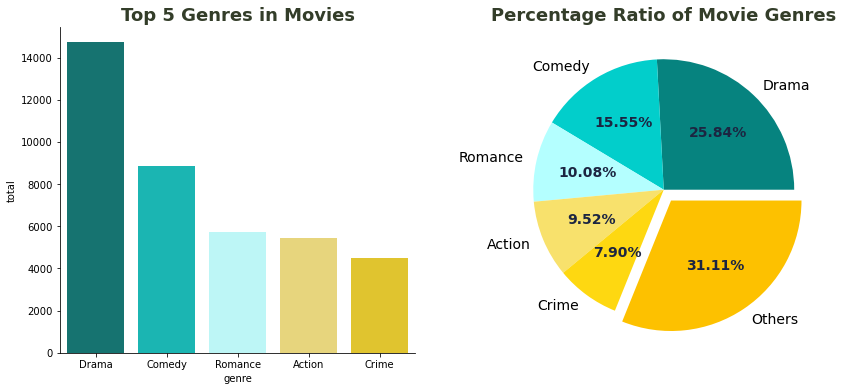

In [60]:
# Create list of genres
genres_list = []
for i in imdb_wiki['genres']:
    genres_list.extend(i.split(','))

# Instantiate plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Create barplot
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], 
                 palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

# Create pie chart
df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')

wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), 
                                       explode=[0,0,0,0,0,0.1], 
                                       colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off');

From the above, we can see a few takeaways:

* Drama is the single most dominant genre with over 14000 movies.
* Out of the top 5 genres, there are still many genres in the dataset. They hold 31.11% of the total genres of the movies.

Let's see if we can look at all of the genres in a different format.

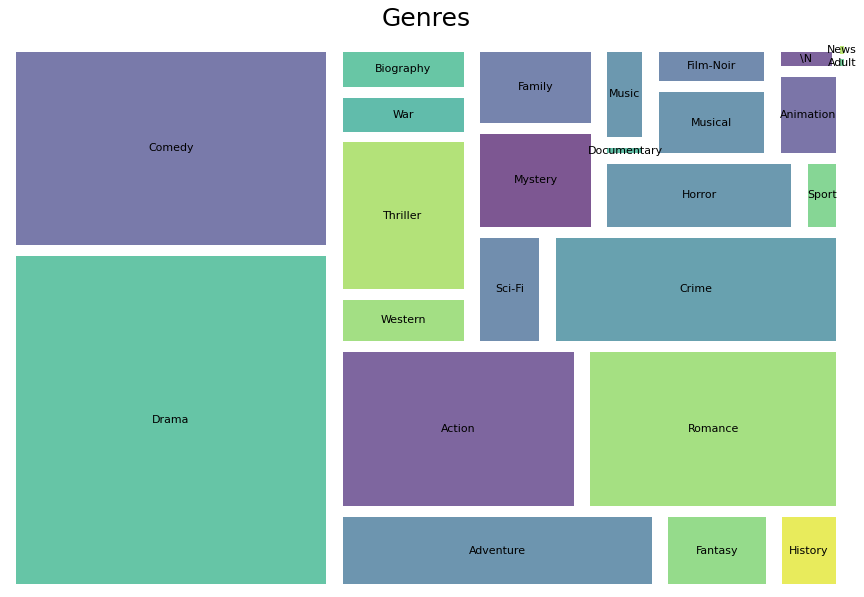

In [68]:
genres_info = Counter(genres_list)

plt.figure(figsize=(15, 10))
plt.title("Genres", fontsize=25, pad=20)
squarify.plot(genres_info.values(), label=genres_info.keys(), text_kwargs={'fontsize':11}, 
              bar_kwargs={'alpha':.7}, pad=True)
plt.axis("off");

We have the same data as our first visual, but this time we can see all of the genres. 

Next, let's take a look to see what year our movies were released.

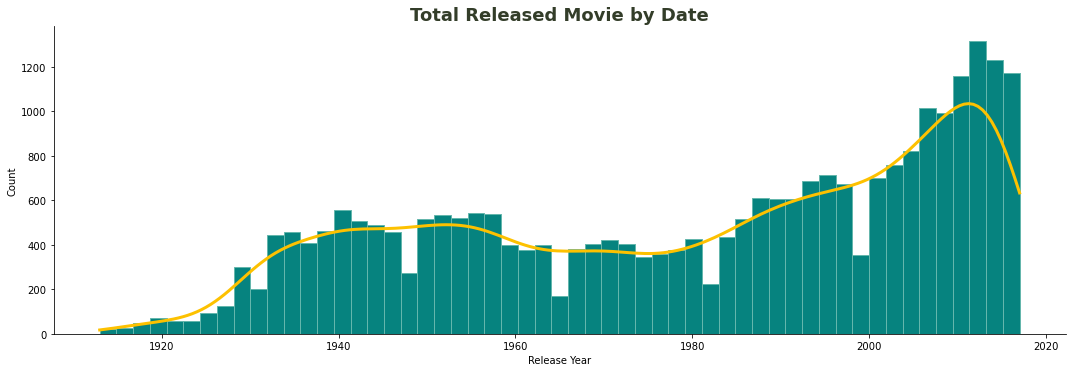

In [65]:
# Change Release Year to integer
imdb_wiki['Release Year'] = imdb_wiki['Release Year'].astype(int)

sns.displot(data=imdb_wiki, x='Release Year', kind='hist', kde=True, bins=55,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)

plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29');

As we can see above, our dataset is skewed right. Once again, this logically makes sense as before because more content is produced in recent years.

Next, let's take a look and see if the movies that are the most popular are the highest rated.

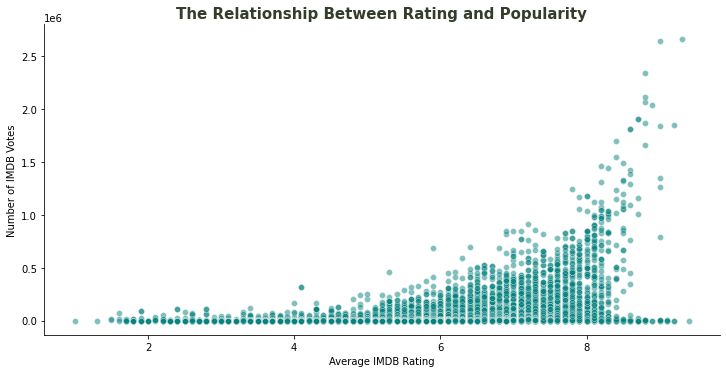

In [66]:
sns.relplot(data=imdb_wiki, x='averageRating', y='numVotes', alpha=.5, aspect=2, color='#06837f')

plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')
plt.xlabel('Average IMDB Rating')
plt.ylabel('Number of IMDB Votes');

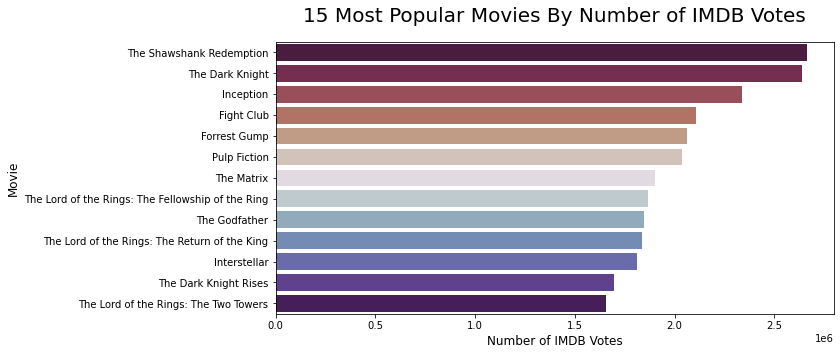

In [70]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,5))

# Get top 15 movies
top_15_popular = imdb_wiki.sort_values(by='numVotes', ascending=False)[:15]

# Plot the data
sns.barplot(data= top_15_popular, x='numVotes', y='Title', palette='twilight_shifted_r')
plt.title("15 Most Popular Movies By Number of IMDB Votes", fontsize=20, pad=20)
plt.xlabel('Number of IMDB Votes', fontsize=12)
plt.ylabel('Movie', fontsize=12);

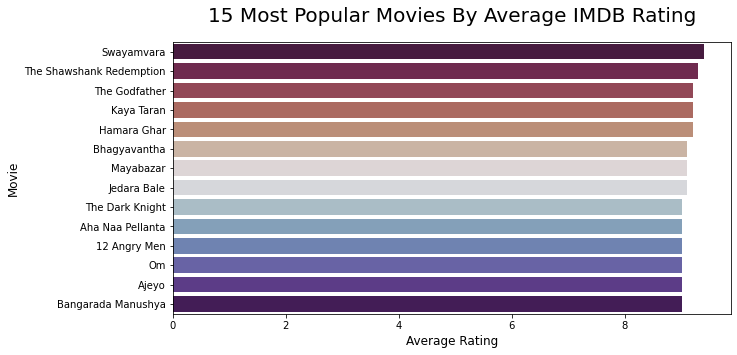

In [71]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,5))

# Get top 15 movies
top_15_popular = imdb_wiki.sort_values(by='averageRating', ascending=False)[:15]

# Plot the data
sns.barplot(data= top_15_popular, x='averageRating', y='Title', palette='twilight_shifted_r')
plt.title("15 Most Popular Movies By Average IMDB Rating", fontsize=20, pad=20)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Movie', fontsize=12);

As we can see above, these two charts have slight differences. *The Shawshank Redemption* and *The Dark Knight* are the two most voted on movies on IMDB. However the highest average rated movies are *Swayamvara* and *The Shawshank Redemption*.

## Modeling

Now that we have a good understanding of our dataframe, we can start creating our second model. As a reminder, we are going to add the below info into our model to go along with the plot description.

* The genre of the movie
* The director of the movie
* Major stars and cast
* Average rating
* Number of IMDB votes

In [75]:
# Function to sanitize data to prevent ambiguity. 
# Removes spaces and converts to lowercase
def sanitize(x):
    if isinstance(x, list):
        #Strip spaces and convert to lowercase
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [77]:
#Apply the generate_list function to cast, keywords, director and genres
for feature in ['Cast', 'genres', 'primaryName']:
    imdb_wiki[feature] = imdb_wiki[feature].apply(sanitize)

In [79]:
imdb_wiki.head()

,Release Year,Title,Cast,Plot,Clean_Plot,runtimeMinutes,genres,averageRating,numVotes,primaryName
0,1913,Atlantis,,"Dr. Friedrich von Kammacher (Olaf Fønss), a su...",dr friedrich von kammacher olaf fønss a surgeo...,121,drama,6.6,424,augustblom
1,1914,The Battle of the Sexes,"donaldcrisp,liliangish","Frank Andrews (Donald Crisp) is a well-to-do, ...",frank andrews donald crisp is a welltodo middl...,50,drama,6.2,99,d.w.griffith
2,1914,Brewster's Millions,"edwardabeles,sydneydeane,josephsingleton",Wealthy Edwin Peter Brewster disowns his son R...,wealthy edwin peter brewster disowns his son r...,\N,comedy,6.7,50,cecilb.demille
3,1914,Brewster's Millions,"edwardabeles,sydneydeane,josephsingleton",Wealthy Edwin Peter Brewster disowns his son R...,wealthy edwin peter brewster disowns his son r...,\N,comedy,6.7,50,oscarapfel
4,1914,The Call of the North,"robertedeson,theodoreroberts","Graehme, Ned Stewart's father was accused of a...",graehme ned stewarts father was accused of adu...,\N,"adventure,drama",5.2,45,cecilb.demille


## 2. MovieLens 100K Data

There are 4 files within the MovieLens 100K dataset:

  * `links`
  * `movies`
  * `ratings`
  * `tags` - DONT THINK WE NEED THIS

In [2]:
# Load the data
links_df = pd.read_csv('Data/MovieLens/ml-latest-small/links.csv')

# Preview the data
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
# Load the data
movies_df = pd.read_csv('Data/MovieLens/ml-latest-small/movies.csv')

# Preview the data
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Load the data
ratings_df = pd.read_csv('Data/MovieLens/ml-latest-small/ratings.csv')

# Preview the data
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# # Load the data
# tags_df = pd.read_csv('Data/MovieLens/ml-latest-small/tags.csv')

# # Preview the data
# tags_df.head()

## 4. Streaming Platform Data

There is 1 file within the OTT Streaming Platform Data set: `MoviesOnStreamingPlatforms_updated`.

In [12]:
# Load the data
streaming_df = pd.read_csv('Data/Streaming Platforms/MoviesOnStreamingPlatforms_updated.csv')

# Preview the data
streaming_df.head()

,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,1,Inception,2010,13+,8.8,87%,1.0,0,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,2,The Matrix,1999,18+,8.7,87%,1.0,0,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,3,Avengers: Infinity War,2018,13+,8.5,84%,1.0,0,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,4,Back to the Future,1985,7+,8.5,96%,1.0,0,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,1.0,0,1,0,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


It looks like our IMDB dataframe is ready to go.

Now let's try merging together the three dataframes from the MovieLens 100K dataset.

In [18]:
# Merge the datasets on `movieId`
movielens_df = pd.merge(links_df, movies_df, on='movieId')

# Merge the datasets on `movieId`
movielens_df = pd.merge(movielens_df, ratings_df, on='movieId')

# Preview the results
movielens_df

,movieId,imdbId,tmdbId,title,genres,userId,rating,timestamp
0,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...,...,...
100831,193581,5476944,432131.0,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,5914996,445030.0,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,6397426,479308.0,Flint (2017),Drama,184,3.5,1537109805
100834,193587,8391976,483455.0,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [19]:
# Checking for missing values
movielens_df.isna().sum()

movieId       0
imdbId        0
tmdbId       13
title         0
genres        0
userId        0
rating        0
timestamp     0
dtype: int64

We won't be using the `tmdbId` column so we can drop that entirely from our dataframe.

In [20]:
# Drop the column
movielens_df.drop('tmdbId', axis=1, inplace=True)

In [21]:
# Checking if it worked
movielens_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   imdbId     100836 non-null  int64  
 2   title      100836 non-null  object 
 3   genres     100836 non-null  object 
 4   userId     100836 non-null  int64  
 5   rating     100836 non-null  float64
 6   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 6.2+ MB


Unfortunately we do not have a 100% distinct column in both the `movielens_df` and `imdb_df` dataframes. 

However, the column `imdbId` from `movielens_df` is appropriate to use for matching this dataset to the `imdb_df` dataset using `tconst`. Let's take a look at this below:

In [22]:
# Preview the first line
movielens_df[:1]

,movieId,imdbId,title,genres,userId,rating,timestamp
0,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703


As we can see, Toy Story has an `imdbId` of `114709`. What is even better is that this matches up with the link to Toy Story on IMDB's website.

> Toy Story: https://www.imdb.com/title/tt0114709/

Let's see if Toy Story appears in our `imdb_df`.

In [23]:
# Check for `imdbId` value
imdb_df.loc[imdb_df['tconst'].str.contains('114709')]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
62400,tt0114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",8.3,989855


Well that actually works well for us. Before going any further, let's try looking at some additional examples:

In [24]:
# Pull another random sample
movielens_df[2989:2990]

,movieId,imdbId,title,genres,userId,rating,timestamp
2989,80,112445,"White Balloon, The (Badkonake sefid) (1995)",Children|Drama,606,4.0,1171409272


In [25]:
# Cross reference the `movieId`
imdb_df.loc[imdb_df['tconst'].str.contains('112445')]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
61219,tt0112445,movie,The White Balloon,Badkonake sefid,0,1995,\N,85,"Drama,Family",7.6,7694
154801,tt11244558,movie,A Thousand Little Cuts,A Thousand Little Cuts,0,2022,\N,87,Thriller,5.0,360


Well that is interesting. We have two `tconst` matches for our one `movieId` column.

After doing a little digging, it is easy to tell that all of the movies we are looking for start with the `tconst` of `tt0`. Let's drop all of the rows from our `imdb_df` that do not include that code:

In [26]:
# Preview the original shape
imdb_df.shape

(283270, 11)

In [27]:
# Filter out movies not containing `tt0`
imdb_df = imdb_df.loc[imdb_df['tconst'].str.contains('tt0')]

print(imdb_df.shape, '\n')
imdb_df.head()

(145092, 11) 



,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,200
1,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.2,14
2,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,796
3,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.1,20
4,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,4.3,23


It appears that we filtered out about ~50% of the rows from our `imdb_df`. However, now we should not have any overlaps when we are trying to merge our two datasets. 

In order to merge the two datasets, we need to change the `imdbId` column into an string so it matches `tconst`. Let's drop the first 3 digits from our `tconst` column so it will match `imdbId` and then change the `imdbId` column to a string.

In [28]:
# Slice each column in `tconst`
imdb_df['tconst'] = imdb_df['tconst'].str[3:]

# Preview the results
imdb_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,200
1,000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.2,14
2,000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,796
3,000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.1,20
4,000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,4.3,23


In [29]:
# Change `imdbId` to a string
movielens_df['imdbId'] = movielens_df['imdbId'].astype('str')

In [30]:
# Merge the two datasets
movielens_imdb = pd.merge(movielens_df, imdb_df, left_on='imdbId', right_on='tconst')

# Preview the results
movielens_imdb.head()

,movieId,imdbId,title,genres_x,userId,rating,timestamp,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_y,averageRating,numVotes
0,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",8.3,989855
1,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",8.3,989855
2,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",8.3,989855
3,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",8.3,989855
4,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",8.3,989855


In [31]:
movielens_imdb.columns

Index(['movieId', 'imdbId', 'title', 'genres_x', 'userId', 'rating',
       'timestamp', 'tconst', 'titleType', 'primaryTitle', 'originalTitle',
       'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres_y',
       'averageRating', 'numVotes'],
      dtype='object')

We can see that we have a good amount of duplicated and unnecessary columns, let's go ahead and filter out the columns we actually want to keep.

In [32]:
# Filter out columns we want
movielens_imdb_df = movielens_imdb[['userId', 'rating', 'tconst', 'primaryTitle','startYear', 
                                   'runtimeMinutes', 'genres_y', 'averageRating', 'numVotes']]

# Preview new dataframe
movielens_imdb_df

,userId,rating,tconst,primaryTitle,startYear,runtimeMinutes,genres_y,averageRating,numVotes
0,1,4.0,114709,Toy Story,1995,81,"Adventure,Animation,Comedy",8.3,989855
1,5,4.0,114709,Toy Story,1995,81,"Adventure,Animation,Comedy",8.3,989855
2,7,4.5,114709,Toy Story,1995,81,"Adventure,Animation,Comedy",8.3,989855
3,15,2.5,114709,Toy Story,1995,81,"Adventure,Animation,Comedy",8.3,989855
4,17,4.5,114709,Toy Story,1995,81,"Adventure,Animation,Comedy",8.3,989855
...,...,...,...,...,...,...,...,...,...
64576,89,2.5,374887,Munna Bhai M.B.B.S.,2003,156,"Comedy,Drama",8.1,82575
64577,599,2.5,223954,The Prime Gig,2000,98,Drama,6.0,2263
64578,105,5.0,809951,Empties,2007,104,"Comedy,Drama",7.2,4877
64579,89,3.5,453047,Elsa & Fred,2005,108,"Comedy,Drama,Romance",7.5,3451


Now we need to work on merging in the plot overview from our Wikipedia dataframe. Fortunately, in order to ensure the integrity of our data, we have two matching columns across the two dataframes:

* The specific title of the movie
* The release year of the movie

In [33]:
# Change `Release Year` to a string
plots_df['Release Year'] = plots_df['Release Year'].astype('str')

In [34]:
# Merge two dataframes
movielens_imdb_wiki = pd.merge(movielens_imdb_df, plots_df, left_on=['primaryTitle', 'startYear'], 
                               right_on=['Title', 'Release Year'])

# Preview new dataframe
movielens_imdb_wiki.head()

,userId,rating,tconst,primaryTitle,startYear,runtimeMinutes,genres_y,averageRating,numVotes,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1,4.0,114709,Toy Story,1995,81,"Adventure,Animation,Comedy",8.3,989855,1995,Toy Story,American,John Lasseter,"Tim Allen, Tom Hanks (voices)",animated film,https://en.wikipedia.org/wiki/Toy_Story,In a world where toys are living things who pr...
1,5,4.0,114709,Toy Story,1995,81,"Adventure,Animation,Comedy",8.3,989855,1995,Toy Story,American,John Lasseter,"Tim Allen, Tom Hanks (voices)",animated film,https://en.wikipedia.org/wiki/Toy_Story,In a world where toys are living things who pr...
2,7,4.5,114709,Toy Story,1995,81,"Adventure,Animation,Comedy",8.3,989855,1995,Toy Story,American,John Lasseter,"Tim Allen, Tom Hanks (voices)",animated film,https://en.wikipedia.org/wiki/Toy_Story,In a world where toys are living things who pr...
3,15,2.5,114709,Toy Story,1995,81,"Adventure,Animation,Comedy",8.3,989855,1995,Toy Story,American,John Lasseter,"Tim Allen, Tom Hanks (voices)",animated film,https://en.wikipedia.org/wiki/Toy_Story,In a world where toys are living things who pr...
4,17,4.5,114709,Toy Story,1995,81,"Adventure,Animation,Comedy",8.3,989855,1995,Toy Story,American,John Lasseter,"Tim Allen, Tom Hanks (voices)",animated film,https://en.wikipedia.org/wiki/Toy_Story,In a world where toys are living things who pr...


Once again, we can drop some unnecessary and repetitive columns:

In [35]:
movielens_imdb_wiki.columns

Index(['userId', 'rating', 'tconst', 'primaryTitle', 'startYear',
       'runtimeMinutes', 'genres_y', 'averageRating', 'numVotes',
       'Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot'],
      dtype='object')

In [36]:
# Filter out columns we want
movielens_imdb_wiki = movielens_imdb_wiki[['userId', 'rating', 'primaryTitle', 'runtimeMinutes', 'genres_y', 
                                           'averageRating', 'numVotes', 'Release Year', 'Plot', 'Cast', 'Director']]

# Preview new dataframe
movielens_imdb_wiki.head()

,userId,rating,primaryTitle,runtimeMinutes,genres_y,averageRating,numVotes,Release Year,Plot,Cast,Director
0,1,4.0,Toy Story,81,"Adventure,Animation,Comedy",8.3,989855,1995,In a world where toys are living things who pr...,"Tim Allen, Tom Hanks (voices)",John Lasseter
1,5,4.0,Toy Story,81,"Adventure,Animation,Comedy",8.3,989855,1995,In a world where toys are living things who pr...,"Tim Allen, Tom Hanks (voices)",John Lasseter
2,7,4.5,Toy Story,81,"Adventure,Animation,Comedy",8.3,989855,1995,In a world where toys are living things who pr...,"Tim Allen, Tom Hanks (voices)",John Lasseter
3,15,2.5,Toy Story,81,"Adventure,Animation,Comedy",8.3,989855,1995,In a world where toys are living things who pr...,"Tim Allen, Tom Hanks (voices)",John Lasseter
4,17,4.5,Toy Story,81,"Adventure,Animation,Comedy",8.3,989855,1995,In a world where toys are living things who pr...,"Tim Allen, Tom Hanks (voices)",John Lasseter


In [37]:
# Check for duplicates
movielens_imdb_wiki.isna().sum()

userId              0
rating              0
primaryTitle        0
runtimeMinutes      0
genres_y            0
averageRating       0
numVotes            0
Release Year        0
Plot                0
Cast              415
Director            0
dtype: int64

In [38]:
# Check amount of unique plots
movielens_imdb_wiki.Plot.unique().size

3045

As we can see here, it looks like films that have higher IMDB ratings do tend to have more IMDB reviews.

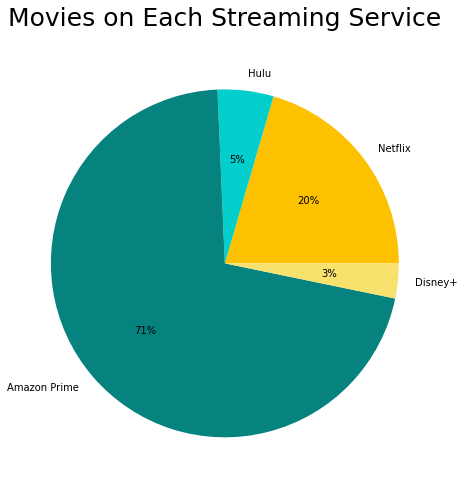

In [43]:
plt.figure(figsize=(8, 8))

# Get totals for each streaming service
netflix_sum = streaming_df['Netflix'].sum().round(0)
hulu_sum = streaming_df['Hulu'].sum().round(0)
prime_sum = streaming_df['Prime Video'].sum().round(0)
disney_sum = streaming_df['Disney+'].sum().round(0)

# Define data
data = [netflix_sum, hulu_sum, prime_sum, disney_sum]
labels = ['Netflix', 'Hulu', 'Amazon Prime', 'Disney+']

colors= ['#fdc100', '#02cecb', '#06837f', '#f8e16c']

# Create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Movies on Each Streaming Service", fontsize=25, pad=20)
plt.show()

Above we can see that the majority of movies between our 4 streaming services are available on Amazon Prime Video at 71%, followed by Netflix at 20%. Disney and Hulu have significantly less movies available therefore we would expect our recommendation engine to recommend those OTT platforms much less frequently than Amazon Prime and Netflix. 

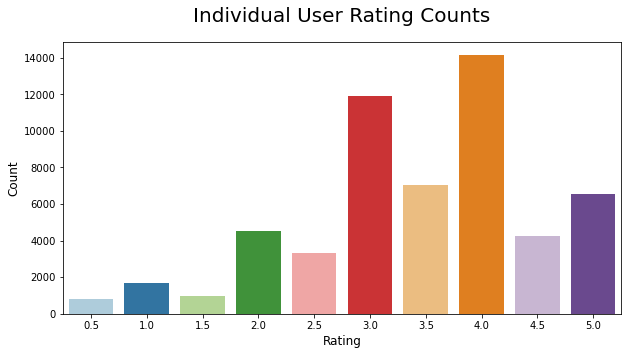

In [46]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,5))

sns.countplot(data=movielens_imdb_wiki, x='rating', palette='Paired')
plt.title("Individual User Rating Counts", fontsize=20, pad=20)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12);

Now that we have done some preliminary exploratory data analysis, it is time to jump in to our modeling. The first step of our modeling is to perform a train test split. Recommendation engines by their very nature are very difficult to evaluate. We won't perform a classic `X_train`, `X_test`, `y_train`, `y_test` split but rather segment the data into two sets of data.

In [56]:
# Perform train test split with random_state = 32
train_data, test_data = train_test_split(movielens_imdb_wiki, random_state=32)

In [57]:
train_data[15:20]

,userId,rating,primaryTitle,runtimeMinutes,genres_y,averageRating,numVotes,Release Year,Plot,Cast,Director
52965,76,3.0,Burn After Reading,96,"Comedy,Crime,Drama",7.0,333298,2008,Faced with a demotion at work due to a drinkin...,"George Clooney, Frances McDormand, John Malkov...",Joel and Ethan Coen
35199,105,4.0,Pearl Harbor,183,"Action,Drama,History",6.2,333787,2001,"In 1923 Tennessee, two best friends, Rafe McCa...","Ben Affleck, Josh Hartnett, Kate Beckinsale, T...",Michael Bay
37068,610,4.0,The Royal Tenenbaums,110,"Comedy,Drama",7.6,293523,2001,Royal Tenenbaum explains to his three adolesce...,"Gene Hackman, Anjelica Huston, Gwyneth Paltrow...",Wes Anderson
55140,497,5.0,Interstellar,169,"Adventure,Drama,Sci-Fi",8.6,1809464,2014,"In the mid-21st century, crop blights and dust...",Anne Hathaway\r\nMatthew McConaughey\r\nJessic...,Christopher Nolan
54929,279,3.0,Jack Reacher,130,"Action,Mystery,Thriller",7.0,342743,2012,"In Pittsburgh, Pennsylvania, a man drives a va...","Tom Cruise, Rosamund Pike, Richard Jenkins, We...",Christopher McQuarrie


## Memory-Based Collaborate Filtering

Memory-Based Collaborative Filtering approaches can be divided into two main sections: **user-item filtering** and **item-item filtering**. 

A *user-item filtering* will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 

In contrast, *item-item filtering* will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations. 

* *Item-Item Collaborative Filtering*: “Users who liked this item also liked …”
* *User-Item Collaborative Filtering*: “Users who are similar to you also liked …”

In both cases, you create a user-item matrix which built from the entire dataset.

Since we have split the data into testing and training we will need to create two ``[943 x 1682]`` matrices (all users by all movies). 

The training matrix contains 75% of the ratings and the testing matrix contains 25% of the ratings.  